# Projet Fil Rouge : AutoEncoder (AE) for anomaly detection based on the electrical load curve

### Install

In [1]:
#!pip install keras
#!pip install tensorflow

## Import libs

In [2]:
# --- ultils libs ---

from typing import List, Set, Dict, Tuple, Optional, Any
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Machine Learning libs ---
import random
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import statistics

# --- Deep Learning Libs ---
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Flatten, BatchNormalization, Activation, Lambda, MaxPooling1D
from keras.losses import mse, binary_crossentropy, categorical_crossentropy
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Nadam, Adadelta
from tensorflow.keras.models import load_model
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from keras.wrappers.scikit_learn import KerasRegressor

# --- Options ---
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)


## Load and Preprocessed Dataset

In [3]:
def load_dataset(filename: str, resample_period :Optional[str]=None) -> pd.DataFrame:
    """
    Loads the dataset
    filename: the path to the file to load
    resample_period: (optional) the reasmple period, if None the default period of 1 second will be used
    returns: a DataFrame containing the dataset
    """
    dataset = pd.read_csv(filename, index_col='datetime').interpolate('linear')
    dataset.index = pd.to_datetime(dataset.index)
    dataset = dataset.asfreq('s')

    if resample_period:
        dataset = dataset.resample(resample_period).nearest()
    
    dataset['hour'] = dataset.index.hour + dataset.index.minute / 60 #+ dataset.index.seconde / 3600

    return dataset

In [4]:
def load_preproc_dataset():
    raw_dataset = pd.read_csv("data/house1_power_blk2_labels.csv", index_col='datetime').interpolate('linear')
    raw_dataset.index = pd.to_datetime(raw_dataset.index)
    raw_dataset = raw_dataset.asfreq('s')

    dataset_resampled = load_dataset("data/house1_power_blk2_labels.csv", "5min")
    dataset_mains_resampled = dataset_resampled["mains"]
    dataset_mains_resampled

    start_time = raw_dataset.index[0]

    #transform to numpy array of 24*356*4 elements
    M = np.array(dataset_mains_resampled)
    lenght = M.shape[0]
    M = M[:-(lenght%24)]
    M = M.reshape(lenght//24,24)

    M = M[~np.all(M == 0, axis=1)]

    M = M.reshape(len(M),24,1)
    for i in range(len(M)):
        M[i] = np.roll(M[i], -start_time.hour)

    #M = preprocessing.normalize(M)
    M = M/(max([max(x) for x in M]))

    U = []
    for x in M:
        RAN = np.array([random.uniform(0, 2) for i in range(24)])
        RAN = np.expand_dims(RAN,axis=1)
        y = x*RAN
        U.append(y)
    V = []
    for x in M:
        RAN = np.array([random.uniform(0, 2) for i in range(24)])
        RAN = np.expand_dims(RAN,axis=1)
        y = x*RAN
        V.append(y)

    for i in range(len(U)):
        U[i] = np.roll(U[i], 8)
        V[i] = np.roll(V[i], -8)

    dada = [0 for i in range(len(M))]
    x_train, x_test, _, __ = train_test_split(M, dada, test_size=0.20)
    u_train, u_test, _, __ = train_test_split(U, dada, test_size=0.20)
    v_train, v_test, _, __ = train_test_split(V, dada, test_size=0.20)

    u_train = np.array(u_train)
    u_test = np.array(u_test)

    return x_train, x_test, u_train, u_test, v_train, v_test 

## Define AE

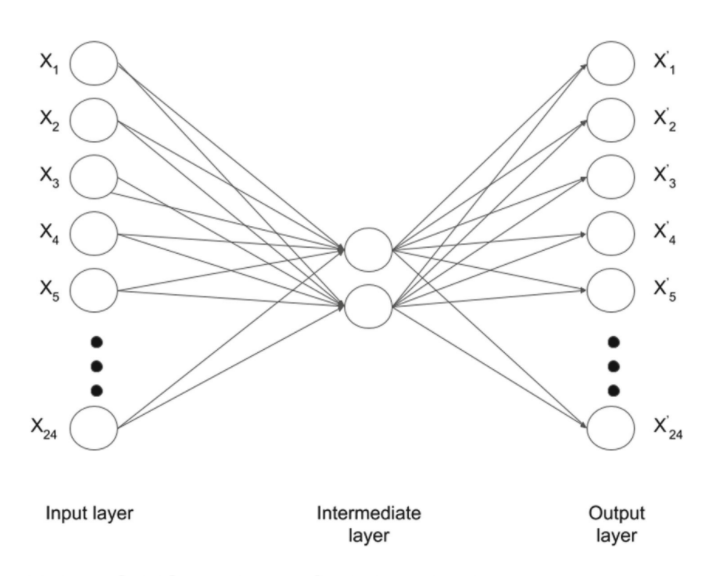

In [5]:
def shallow(optimizer='Nadam', loss='categorical_crossentropy', mid_activation='sigmoid', out_activation='sigmoid'):
    
    input_window = Input(shape=(window_length,))
    

    encoded = Dense(latent_size, activation=mid_activation)(input_window)
    
    decoded = Dense(window_length, activation=out_activation)(encoded)

    encoder = Model(input_window, encoded)
    autoencoder = Model(input_window, decoded)

    autoencoder.compile(optimizer=optimizer, loss=loss)

    return autoencoder, encoder

## Build train set and test set

In [6]:
x_train, x_test, x_train_shifted_8, x_test_shifted_8, v_train, v_test  = load_preproc_dataset()
x_train = np.squeeze(x_train, axis=2)
x_test = np.squeeze(x_test, axis=2)
x_train_shifted_8 = np.squeeze(x_train_shifted_8, axis=2)
x_test_shifted_8 = np.squeeze(x_test_shifted_8, axis=2)
v_train = np.squeeze(v_train, axis=2)
v_test = np.squeeze(v_test, axis=2)


#train_set = np.concatenate((x_train,x_train_shifted_8), axis=0)
train_set = x_train
test_set = x_test
pos_shifted_train_set = x_train_shifted_8
pos_shifted_set = x_test_shifted_8
neg_shifted_set = v_test

## Define hyperparameters

- ``latent_size`` : 2
- ``window_length`` : 24
- ``optimizer`` : Nadam
- ``loss`` : categorical_crossentropy
- ``mid_activation`` : sigmoid
- ``out_activation`` : sigmoid

In [7]:
latent_size = 2
window_length=24
optimizer='Nadam'
loss='categorical_crossentropy'
mid_activation='sigmoid'
out_activation='sigmoid'

## Train AE

- ``batch_size`` : 32
- ``epochs``: 200

In [8]:
autoencoder, encoder = shallow()
autoencoder.fit(train_set, train_set, batch_size=32,
                epochs=200, shuffle=True)

Epoch 1/200
19/19 [==============================] - 1s 1ms/step - loss: 8.6468
Epoch 2/200
19/19 [==============================] - 0s 1ms/step - loss: 8.6462
Epoch 3/200
19/19 [==============================] - 0s 1ms/step - loss: 8.6464
Epoch 4/200
19/19 [==============================] - 0s 1ms/step - loss: 8.6472
Epoch 5/200
19/19 [==============================] - 0s 1ms/step - loss: 8.6485
Epoch 6/200
19/19 [==============================] - 0s 1ms/step - loss: 8.6502
Epoch 7/200
19/19 [==============================] - 0s 1ms/step - loss: 8.6525
Epoch 8/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6551
Epoch 9/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6582
Epoch 10/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6618
Epoch 11/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6660
Epoch 12/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6699
Epoch 13/200
19/19 [=================

19/19 [==============================] - 0s 2ms/step - loss: 8.6852
Epoch 103/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6852
Epoch 104/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6848
Epoch 105/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6847
Epoch 106/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6846
Epoch 107/200
19/19 [==============================] - 0s 1ms/step - loss: 8.6844
Epoch 108/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6844
Epoch 109/200
19/19 [==============================] - 0s 1ms/step - loss: 8.6842
Epoch 110/200
19/19 [==============================] - 0s 1ms/step - loss: 8.6840
Epoch 111/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6842
Epoch 112/200
19/19 [==============================] - 0s 2ms/step - loss: 8.6839
Epoch 113/200
19/19 [==============================] - 0s 1ms/step - loss: 8.6837
Epoch 114/200
19/19 [=========

## Get the latent space of the AE

In [9]:
latent_train = encoder.predict(train_set)
latent_shifted_train = encoder.predict(pos_shifted_train_set)
latent_test = encoder.predict(test_set)
latent_shifted_pos = encoder.predict(pos_shifted_set)

## Visualize the latent space

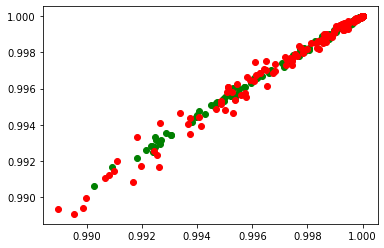

In [10]:
if latent_size == 2:
    X,Y = latent_test.T
    XN,YN = latent_shifted_pos.T
    #XNN,YNN = latent_shifted_neg.T
    plt.plot(X, Y, 'go')
    plt.plot(XN, YN, 'ro')
    #plt.plot(XNN, YNN, 'yo')
elif latent_size ==3:
    from mpl_toolkits.mplot3d import axes3d

    data = (latent_test, latent_shifted_pos,latent_shifted_neg)
    colors = ("green", "red", "yellow")
    groups = ("normal", "anomaly", "anomaly")

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax = fig.gca(projection='3d')


    #X,Y,Z = latent_test.T
    #XN,YN,ZN = latent_shifted_pos.T
    for data, color, group in zip(data, colors, groups):
        x, y, z = data.T
        ax.scatter(x, y, z, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
else:
    pass


## Prepare latent data for classification

In [11]:
def class_preprocess(latent_test, latent_ran_test):
    L = []
    len(L)
    for x in latent_test:
        L.append([x,0])
    for x in latent_ran_test:
        L.append([x,1])

    L = np.array(L)
    np.random.shuffle(L)
    L.shape
    L[0]
    L[1]

    inputs = [x[0] for x in L]
    targets = [x[1] for x in L]
    
    print("-- Input --")
    print(inputs)
    
    print("\n\n-- Targets --")
    print(targets)

    return inputs, targets

## Build train set and test set for the classifier model

In [12]:
#train
features_matrix_train, labels_train = class_preprocess(latent_train, latent_shifted_train)

#test
features_matrix_test, labels_test = class_preprocess(latent_test, latent_shifted_pos)

-- Input --
[array([0.9999709, 0.9999814], dtype=float32), array([0.99316895, 0.994066  ], dtype=float32), array([0.9999865, 0.9999896], dtype=float32), array([0.9997691 , 0.99980164], dtype=float32), array([0.9939207, 0.9942442], dtype=float32), array([0.994488 , 0.9947238], dtype=float32), array([0.9998423, 0.9998865], dtype=float32), array([0.99976134, 0.9998354 ], dtype=float32), array([0.9925039, 0.9927008], dtype=float32), array([0.9994077, 0.9994333], dtype=float32), array([0.99947697, 0.9996643 ], dtype=float32), array([0.9999996 , 0.99999976], dtype=float32), array([0.99291915, 0.99301803], dtype=float32), array([0.9998948 , 0.99989986], dtype=float32), array([0.9940045, 0.9941111], dtype=float32), array([0.9929304 , 0.99402696], dtype=float32), array([0.99993867, 0.9999411 ], dtype=float32), array([0.9948398, 0.9952543], dtype=float32), array([0.99822056, 0.9985018 ], dtype=float32), array([0.99820113, 0.99844587], dtype=float32), array([0.99486077, 0.99498415], dtype=float32

## Train the classifier model

In [13]:
#create and train the random forest classifier
classifier = RandomForestClassifier()
classifier.fit(features_matrix_train, labels_train)

RandomForestClassifier()

## Predict and Evaluate

In [14]:
#predict and evaluate
predicted_labels_test = classifier.predict(np.array(features_matrix_test))

print("---- Confusion matrix ----")
print(confusion_matrix(labels_test,predicted_labels_test))

print("\n\n---- Classification Report ----\n")
print(classification_report(labels_test,predicted_labels_test))

---- Confusion matrix ----
[[88 63]
 [63 88]]


---- Classification Report ----

              precision    recall  f1-score   support

           0       0.58      0.58      0.58       151
           1       0.58      0.58      0.58       151

    accuracy                           0.58       302
   macro avg       0.58      0.58      0.58       302
weighted avg       0.58      0.58      0.58       302

